In [65]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.stats.api as sms
import math as math
from scipy import stats
from statsmodels.stats.power import TTestIndPower


In [66]:
import seaborn as sns

In [142]:
import altair as alt

In [67]:
path = 'Asset/tedsd_puf_2019.dta'
df_discharge_2019 = pd.read_stata(path)

In [68]:
df_discharge_2019.columns

Index(['DISYR', 'CASEID', 'STFIPS', 'CBSA2010', 'EDUC', 'MARSTAT', 'SERVICES',
       'DETCRIM', 'LOS', 'PSOURCE', 'NOPRIOR', 'ARRESTS', 'EMPLOY', 'METHUSE',
       'PSYPROB', 'PREG', 'GENDER', 'VET', 'LIVARAG', 'DAYWAIT', 'SERVICES_D',
       'REASON', 'EMPLOY_D', 'LIVARAG_D', 'ARRESTS_D', 'DSMCRIT', 'AGE',
       'RACE', 'ETHNIC', 'DETNLF', 'DETNLF_D', 'PRIMINC', 'SUB1', 'SUB2',
       'SUB3', 'SUB1_D', 'SUB2_D', 'SUB3_D', 'ROUTE1', 'ROUTE2', 'ROUTE3',
       'FREQ1', 'FREQ2', 'FREQ3', 'FREQ1_D', 'FREQ2_D', 'FREQ3_D', 'FRSTUSE1',
       'FRSTUSE2', 'FRSTUSE3', 'HLTHINS', 'PRIMPAY', 'FREQ_ATND_SELF_HELP',
       'FREQ_ATND_SELF_HELP_D', 'ALCFLG', 'COKEFLG', 'MARFLG', 'HERFLG',
       'METHFLG', 'OPSYNFLG', 'PCPFLG', 'HALLFLG', 'MTHAMFLG', 'AMPHFLG',
       'STIMFLG', 'BENZFLG', 'TRNQFLG', 'BARBFLG', 'SEDHPFLG', 'INHFLG',
       'OTCFLG', 'OTHERFLG', 'DIVISION', 'REGION', 'IDU', 'ALCDRUG'],
      dtype='object')

In [69]:
corrs = df_discharge_2019[[ 'EDUC', 'MARSTAT', 'SERVICES',
       'DETCRIM', 'LOS', 'PSOURCE', 'NOPRIOR', 'ARRESTS', 'EMPLOY', 'METHUSE',
       'PSYPROB', 'LIVARAG', 'DAYWAIT',
       'REASON',  'DSMCRIT', 'AGE',
       'RACE', 'ETHNIC', 'DETNLF', 'PRIMINC', 'SUB1', 'ROUTE1',
       'FREQ1', 'FRSTUSE1', 'HLTHINS', 'PRIMPAY', 'FREQ_ATND_SELF_HELP',
       'IDU', 'ALCDRUG']].corr()

In [70]:
corrs_D= df_discharge_2019[[ 'EDUC', 'MARSTAT',
       'DETCRIM', 'LOS', 'PSOURCE', 'NOPRIOR',   'METHUSE',
       'PSYPROB',  'DAYWAIT', 'SERVICES_D',
       'REASON', 'EMPLOY_D', 'LIVARAG_D', 'ARRESTS_D', 'DSMCRIT', 'AGE',
       'RACE', 'ETHNIC', 'DETNLF_D', 'PRIMINC',  'SUB1_D', 'ROUTE1',
       'FREQ1_D', 'FRSTUSE1', 'HLTHINS', 'PRIMPAY', 
       'FREQ_ATND_SELF_HELP_D','IDU', 'ALCDRUG']].corr()

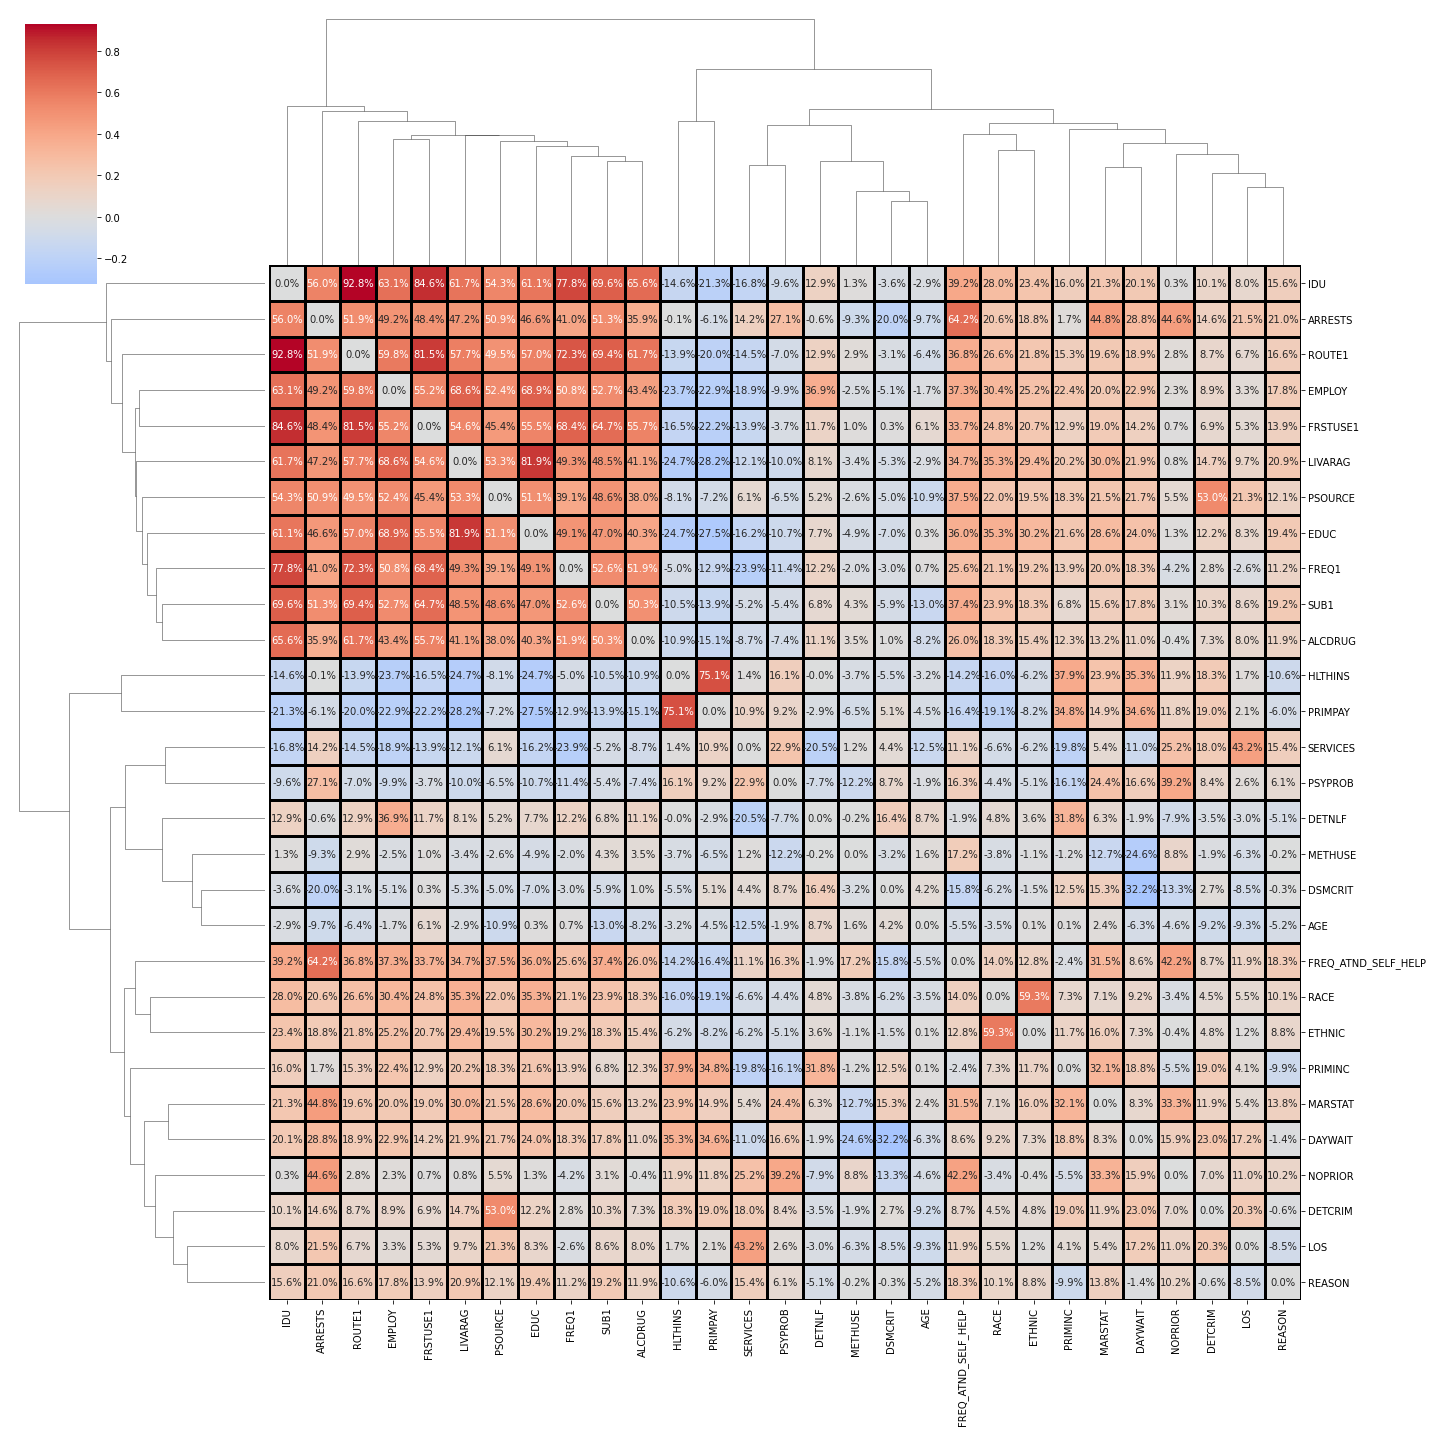

In [71]:
np.fill_diagonal(corrs.values, 0)
corr_map = sns.clustermap(corrs, figsize=(20,20), cmap="coolwarm", center=0.00, annot=True, fmt ='.1%', 
            linewidths=1.3, linecolor='black', cbar=True)

### Background: Why are we uisng the Diff-in-Diff

Our analysis falls into the `observational study` domain. All datasets are prerecorded, and the records indices are organized by the case (admission registration) rather than individuals. Repetitive admission of the same individual could be reported as multiple distinct cases. By the nature of the dataset, we could not perform randomization on the individual level. 

In addition, the `compound variables` and `multicollinearity` among different labels are beyond our scope of the study. We choose the `diff-in-diff` method as our primary and central statistical analysis approach, for it requires the `least strict condition` on the `exchangeability assumption`. 

`Biases` and `unobserved variable` are the significant barriers we encountered when conducting `treatment effectiveness analysis`. Specifically, we believe there might be hidden characteristics that result in a `permanent/pre-treatment differences` between the substance use individuals. However, as we could safely assume that the unobserved or predetermined differences between individuals shall not change drastically after the treatment, the diff-in-diff approach share provides more robust statistical inferences on the `selected groups` of the dataset.

In [72]:
df_discharge_2019.REASON.unique()

array([1., 3., 4., 2., 7., 5., 6.])

### Treatment Variable: literally 

We leverage the `REASON` label as our treatment Variable. The label records the `Reason for discharge`, which have a categorical integer value from 1 to 7. 

All records with the `Treatment completed` status, recorded as `1` under the `REASON` label, constitute the `treatment group`. All other records are considered in the `control group`, for we either could not observe the treatment effect (in the case of `Transferred` and `Other`) or the treatment was interrupted for several reasons.

The `control group` in this set contains the records with the following discharge reasons:
- `2: Dropped out of treatment`
- `3: Terminated by facility`
- `4: Transferred to another treatment program or facility`
- `5: Incarcerated`
- `6: Death`
- `7: Other`

We would also check the statistical inferences with smaller `control group` space. For instance, remove the `6: Death` or `5: Incarcerated`.

In [73]:
# The function could be used if we like to exclude certain value in REASON
def treatment_variable_transform(df, drop_value:list = None):
    df_processing = df.copy()

    # Drop certain record with REASON equals certain value(s)
    if drop_value:
        for value in drop_value:
            df_processing.drop(df_processing.index[df_processing['REASON'] == value], inplace=True)
    
    # Create the Treatment variable column with value 1 and 0 only
    df_processing['Treatment_Completed'] = (df_processing.REASON == 1)
    df_processing.replace(True, 1, inplace = True)
    df_processing.replace(False, 0,  inplace = True)

    df_transformed = df_processing
    return df_transformed

In [74]:
# treatment_variable_transform(df, drop_value = [7])
# treatment_variable_transform(df, drop_value = [6,7])
# treatment_variable_transform(df, drop_value = [5, 6,7])

### Dependent Variable: What do we use to evaluate the treatment effect

Our goal is to conduct comparisons for each `case` on the differences between pre-treatment and post-treatment. Unfortunately, there are no metrics to measure the treatment effect directly. Still, we could construct the evaluation by capturing that difference from multiple aspects with the fundamental rationale and common sense in mind.

Specifically, the following aspect are captured during our scanning:
- Substance use (primary) : `SUB1` & `SUB1_D`
- Frequency of use (primary) : `FREQ1` & `FREQ1_D`

<!-- FREQ_ATND_SELF_HELP_D: Attendance at substance use self-help groups in past 30days prior to discharge -->

In [75]:
def evaluate_matrix(df, diff_label:str = None, selected_label:list = None):
    df_processing = df.copy()

    for label in selected_label:
        df_processing = df_processing.dropna(subset = [label])
        df_processing.drop(df_processing.index[df_processing[label] == -9], inplace=True)
    df_processing[diff_label] = df_processing[selected_label[0]] - df_processing[selected_label[1]]

    return df_processing

In [76]:
# evaluate_matrix(df, diff_label:str = 'usage_difference', selected_label:list = ['SUB1', 'SUB1_D'])
# evaluate_matrix(df, diff_label:str = 'freq_difference', selected_label:list = ['FREQ1', 'FREQ1_D'])


### Data filter variables

We would like to break the dataset by the following filter varibles to observe the treatment effectiveness differences among the subgroups of data.

- `SERVICES_D`: Type of treatment/service setting at discharge
- `STFIPS`: Census state FIPS code
- `NOPRIOR`: Previous substance use treatment episodes

In [77]:
def dataset_on_filter(df, filter_one:dict = None, filter_two:dict = None, filter_three:dict = None):
    df_processing = df.copy()

    if filter_one:
        for value in filter_one:
            df_processing = df_processing[df_processing[value] == filter_one[value]]

    if filter_two:
        for value in filter_two:
            df_processing = df_processing[df_processing[value] == filter_two[value]]

    if filter_three:
        for value in filter_three:
            df_processing = df_processing[df_processing[value] == filter_three[value]]

    df_filtered = df_processing.copy()
    name_str = '{}_{}_{}'.format(filter_one, filter_two, filter_three)
    df_filtered.name = name_str
    return df_filtered

In [78]:
# dataset_on_filter(df, filter_one = {'SERVICES_D':5}, 
#                       filter_two = {'STFIPS':23}, 
#                       filter_three = {'NOPRIOR':1})

In [79]:
df_treatment = treatment_variable_transform(df_discharge_2019, drop_value = [6,7])
df_treatment.REASON.unique()

array([1., 3., 4., 2., 5.])

In [80]:
df_treatment.Treatment_Completed.unique()

array([1, 0], dtype=int64)

In [81]:
# df = evaluate_matrix(df, diff_label = 'usage_difference', selected_label = ['SUB1', 'SUB1_D'])
df_evaluation = evaluate_matrix(df_treatment, diff_label = 'freq_difference', selected_label = ['FREQ1', 'FREQ1_D'])
df_evaluation.freq_difference.unique()

array([ 0.,  1., -2.,  2., -1.])

In [82]:
df_test_1 = dataset_on_filter(df_evaluation, filter_one = {'SERVICES_D':5}, 
                      filter_two = {'STFIPS':23}, 
                      filter_three = {'NOPRIOR':1})
df_test_1.shape


(350, 78)

In [83]:
df_test_2 = dataset_on_filter(df_evaluation, filter_one = {'SERVICES_D':5}, 
                      filter_two = {'STFIPS':23})
df_test_2.shape

(411, 78)

In [84]:
df_test_3 = dataset_on_filter(df_evaluation, 
                      filter_two = {'STFIPS':23})
df_test_3.shape

(5876, 78)

#### Control & Treatment data test

In [85]:
def pre_treatment_stats(df_transformed):
    ## Manually check the differences in means of pre-rating values between the control and treatment groups.
    
    control = np.array(df_transformed[df_transformed.Treatment_Completed == 0 ].FREQ1)
    conformity = np.array(df_transformed[df_transformed.Treatment_Completed == 1].FREQ1)
    t_stats, p_value = stats.ttest_ind(control, conformity)
    
    pr_df = pd.DataFrame([[round(control.mean(), 2),
                           round(conformity.mean(), 2),
                           round(t_stats, 2),
                           round(p_value, 2)]],
                         columns = ['avg control', 'avg treatment', 't-statistic', 'p-value']
                        )
    
    return pr_df

In [86]:
# # df_test_3.FREQ1
# control = np.array(df_test_3[df_test_3.Treatment_Completed == 0 ].FREQ1)
# conformity = np.array(df_test_3[df_test_3.Treatment_Completed == 1].FREQ1)
# t_stats, p_value = stats.ttest_ind(control, conformity)

#### Very minor differences. We ran the similarity check on all states in the cluster 0

In [87]:
pre_treatment_stats(df_test_3)

,avg control,avg treatment,t-statistic,p-value
0,2.39,2.33,2.99,0.0


In [93]:
state_cluster_0 = [ 1.0,  4.0,  5.0,  6.0,  8.0,  9.0, 10.0, 13.0, 15.0, 17.0, 18.0,
              19.0, 20.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0,
              31.0, 32.0, 34.0, 36.0, 39.0, 40.0, 44.0, 45.0, 46.0, 47.0, 48.0,
              49.0, 50.0, 55.0, 72.0]
new_df = np.stack(pre_treatment_stats(dataset_on_filter(df_evaluation, filter_one = {'STFIPS':i})).values[0] for i in state_cluster_0)
# new_df

D:\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3301: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [94]:
new_df.shape

(37, 4)

In [95]:
pre_treatment_check = pd.DataFrame(new_df, columns = ['avg control', 'avg treatment', 't-statistic', 'p-value'], 
                                           index = state_cluster_0)

In [96]:
pre_treatment_check

,avg control,avg treatment,t-statistic,p-value
1.0,2.08,1.75,18.84,0.00
4.0,2.48,2.34,1.83,0.07
5.0,2.26,2.09,11.67,0.00
6.0,2.12,1.76,47.40,0.00
8.0,1.91,2.12,-28.69,0.00
9.0,1.98,2.13,-21.45,0.00
10.0,2.38,2.64,-13.12,0.00
13.0,2.05,2.73,-62.91,0.00
15.0,1.92,2.25,-15.46,0.00
17.0,2.38,2.33,5.16,0.00


In [109]:
def ate(df_diff_Treated):
    

    X = df_diff_Treated.Treatment_Completed
    y = df_diff_Treated.freq_difference
    X = sm.add_constant(X)
    est=sm.OLS(y, X).fit()
#     t_stats = est.params
    t_test = est.t_test('Treatment_Completed').tvalue[0][0]
    p_value = est.pvalues
    
    did_df = pd.DataFrame([[round(t_test,4),
                            round(p_value[1],4)]],
                          columns = ['t-statistic', 'p-value'])
                           
    did_df.name = 'Average Treatment Effect on Delta'
    
    return did_df

In [110]:
# the diff-in-diff result of 23: Maine
ate(df_test_3)

,t-statistic,p-value
0,-2.458,0.014


In [124]:
def ate_on_state(df, drop_Exclude:list = None, state:int = None, filter_two:dict = None):
    df_transformed = treatment_variable_transform(df, drop_value = drop_Exclude)
    df_processing = evaluate_matrix(df_treatment, diff_label = 'freq_difference', selected_label = ['FREQ1', 'FREQ1_D'])
    df_test = dataset_on_filter(df_processing, filter_one = {'STFIPS':state}, filter_two = filter_two)
    did_df = ate(df_test)
    return did_df
                      

In [129]:
ate_on_state(df_discharge_2019, drop_Exclude = [6,7], state = 23)

,t-statistic,p-value
0,-2.458,0.014


In [135]:
ate_df = np.stack([ate_on_state(df_discharge_2019, drop_Exclude = [6,7], state = i).values[0] for i in state_cluster_0])
ate_df = pd.DataFrame(ate_df, columns = ['t-statistic',	'p-value'], 
                                         index = state_cluster_0)

In [155]:
state_stfps = pd.read_csv("Census state FIPS code.txt", sep=" ", header=0, names = ['STFIPS', 'State', 'Frequency', 'Percentage'], index_col=0)
ate_df['significant'] = ate_df['p-value']< 0.01
ate_df_plot = pd.merge(ate_df, state_stfps, left_index=True, right_index=True)

In [156]:
alt.Chart(ate_df_plot).mark_circle(size=50).encode(
    x='p-value',
    y='t-statistic',
    color='significant:N',
    tooltip=['state', 't-statistic', 'p-value', 'Frequency', 'Percentage']
).interactive()

alt.Chart(...)